<a href="https://colab.research.google.com/github/MMucahit/PyhtonDerinOrenmeFrancoisChollet/blob/main/Reuters(%C3%87oklu_S%C4%B1n%C4%B1fland%C4%B1rma).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPU mu kullanıyoruz ?

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Hangi GPU kullanıyoruz ?

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4250935849194686813, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3527979111933076742
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

Veri Setini Yükleme

In [3]:
## Metin sınıflandırmada sıkça kullanılan bir veri setidir. 46 farklı konu bulunur. Bazı konularda daha fazla örnek olsada her konudan en az 10 örnek bulunmaktadır.

from keras.datasets import reuters

In [4]:
num_words = 10000
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words= num_words) ## En sık karşılaşılan 10000 kelime  

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [6]:
print('num of train_data: ',len(train_data))
print('num of test_data: ',len(test_data))

num of train_data:  8982
num of test_data:  2246


In [8]:
print(train_data[10]) ## IMDB veri setinde olduğu gibi her örnek tam sayılardan oluşan bir listedir.

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [121]:
word_index = reuters.get_word_index() ## kelime ve indexleri sözlük içerisinde verilmiş.
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) ## sözlükdeki kelime ve indexleri ters çevirme işlemi
decode_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]]) ## train_data daki haberleri text e çevirmek için yazılmış bir kod parçası.
print('train_data[0]: ', decode_newswire)
print('train_data[0] ın kategorisi: ', train_labels[0])

train_data[0]:  ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
train_data[0] ın kategorisi:  3


Verileri Hazırlama

In [21]:
import numpy as np

In [24]:
def vectorize_sequence(sequences, dimension = num_words):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1
  return results  

In [25]:
x_train = vectorize_sequence(train_data) ## Eğitim verisinin vektöre dönüştürülmesi
x_test = vectorize_sequence(test_data) ## Test verisinin vektöre dönüştürülmes

In [42]:
num_of_labels = max([max(sequence) for sequence in [train_labels]])
num_of_labels

45

In [28]:
## Etiketleri One hot encode edilmesi ilk yöntem
def to_one_hot(labels, dimension = num_of_labels + 1):  ## +1 indisin 0 dan başlamasından dolayı
  results = np.zeros((len(labels), dimension))
  for i, label in enumerate(labels):
    results[i, label] = 1
  return results  

In [29]:
## Eğitim etiketlerinin vektöre dönüştürülmesi
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
## Kerasta one_hot yapmanın başka bir yolu ise:
from keras.utils.np_utils import to_categorical

In [32]:
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

Ağı İnşa Etme

In [33]:
## IMBD(ikili sınıflandırmadan) farkı etiket sayısı 2 den 46 ya çıkmasıdır. IMDB de kullandığımız Dense katmanlarında her katman kendisinden önceki katmanın çıktı bilgisine ulaşabiliyor.
## Eğer bir katman bu bilgiyi öğrenemezse sonraki katmanın bunu telafi etmen şansı yok ve katmanların bir darboğaz haline gelme ihtimali bulunmaktadır.
## IMDB de 16 nöron ile ağı inşa etmiştirk bu örnekte 16 nöron yetersin kalacaktır. Böyle küçük katmanlar ileriye gerekli bilgiyi taşıyamadıkları için darboğaz oluşturacaklardır.
## Bu sebeble 64 nöron kullanacağız.

from keras import models
from keras import layers

In [48]:
model = models.Sequential()
model.add(layers.Dense(64, activation= 'relu', input_shape = (num_words,)))
model.add(layers.Dense(64, activation= 'relu',))
model.add(layers.Dense(num_of_labels + 1, activation = 'softmax')) 
## Bu ağın çıktısının 46 farklı sınıfa ait olasılık dağılımı olaçağı anlamına gelmektedir. 
## Her girdi için 46 boyutlu bir vektör çıkacak ve output[i] i'inci sınıfa ait ait olma olasılığını gösterecektir. Bu 46 değerinin toplamı 1 olacaktır.

model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy']) ## Categorical_crossentropy iki olasılık arasındaki mesafeyi ölçer.

Validation Verisi Oluşturma

In [50]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Modelin Eğitilmesi

In [51]:
epoch = 20
batch = 512
history = model.fit(partial_x_train, partial_y_train, epochs = epoch, batch_size= batch, validation_data = (x_val, y_val))

Epoch 1/20
16/16 [==============================] - 3s 25ms/step - loss: 3.1481 - accuracy: 0.4264 - val_loss: 1.6574 - val_accuracy: 0.6400
Epoch 2/20
16/16 [==============================] - 0s 15ms/step - loss: 1.4180 - accuracy: 0.7040 - val_loss: 1.2897 - val_accuracy: 0.7380
Epoch 3/20
16/16 [==============================] - 0s 15ms/step - loss: 1.0613 - accuracy: 0.7767 - val_loss: 1.1219 - val_accuracy: 0.7600
Epoch 4/20
16/16 [==============================] - 0s 16ms/step - loss: 0.8241 - accuracy: 0.8236 - val_loss: 1.0454 - val_accuracy: 0.7780
Epoch 5/20
16/16 [==============================] - 0s 15ms/step - loss: 0.6571 - accuracy: 0.8608 - val_loss: 0.9640 - val_accuracy: 0.8000
Epoch 6/20
16/16 [==============================] - 0s 15ms/step - loss: 0.5100 - accuracy: 0.8925 - val_loss: 0.9475 - val_accuracy: 0.8020
Epoch 7/20
16/16 [==============================] - 0s 15ms/step - loss: 0.4134 - accuracy: 0.9141 - val_loss: 0.9543 - val_accuracy: 0.7960
Epoch 8/20
16

Eğitim ve Doğrulama Kayıplarını Çizdirme

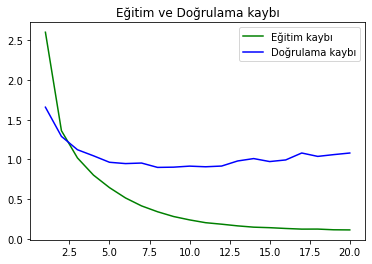

In [52]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g', label = 'Eğitim kaybı')
plt.plot(epochs, val_loss, 'b', label = 'Doğrulama kaybı')
plt.title('Eğitim ve Doğrulama kaybı')
plt.xlabel = 'Epoklar'
plt.ylabel = 'Kayığ'
plt.legend()
plt.show()

Eğitim ve Doğrulama Başarımını Çizdirme

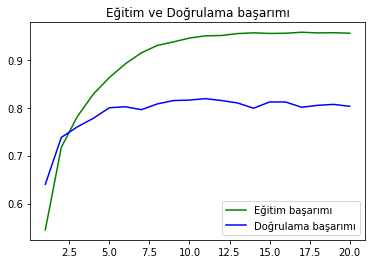

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label = 'Eğitim başarımı')
plt.plot(epochs, val_acc, 'b', label = 'Doğrulama başarımı')
plt.title('Eğitim ve Doğrulama başarımı')
plt.xlabel = 'Epoklar'
plt.ylabel = 'Başarım'
plt.legend()
plt.show()

In [54]:
## Model 9. epokdan sonra overfitt olmaktadır. 9 Epok da durdurulabilir.
results = model.evaluate(x_test, one_hot_test_labels)
results

71/71 [==============================] - 0s 3ms/step - loss: 1.2414 - accuracy: 0.7845


[1.2414286136627197, 0.7845057845115662]

Tahmin

In [57]:
predictions = model.predict(x_test)
print(predictions[0].shape) ## Tahmin çıktısı 46 boyutludur.
print(np.sum(predictions[0])) ## Çıktının toplamları 1 dir.

(46,)
1.0


Yorumları texte çevirme ve categorylerini görme işlemi

In [78]:
def Text(index):
  decode_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[index]])
  return str(decode_newswire), test_labels[index]

In [83]:
text = Text(500)
print('text: ', text[0],end='\n\n')
print('category: ', text[1])

text:  ? shr profit three cts vs profit one ct net profit 129 082 vs profit 36 099 revs 3 864 187 vs 1 875 919 nine mths shr loss six cts vs profit two cts net loss 303 581 vs profit 110 311 revs 9 517 242 vs 5 248 105 note prior qtr and nine mth figures include ? of 15 000 dlrs and 48 000 dlrs respectively reuter 3

category:  3


Çevirdiğimiz text'i vectöre çevirip tahminde bulunma işlemi

In [81]:
text = text[0] 

import re

predict_words = re.sub('[.!,;?]', ' ', text).split()
predict_word_index = [word_index[word] + 3 for word in predict_words]
predict_data_x = np.zeros(num_words)
predict_data_x[predict_word_index] = 1
predict_data_x = predict_data_x.reshape(1, num_words)

result = model.predict(predict_data_x)
category = np.argmax(result)
print('category = {}'.format(category))

category = 3


# İleri Gözlemler

- Etiketleri Ve Kaybı işlemenin alternatif yolu

In [ ]:
## Etiketleri işleminin bir yoluda tam sayı tensörlerine çevirmektir.

In [84]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [ ]:
## Etiketleri bu şekilde kullanmak için kayıp fonksiyonunu değiştirmek zorunda kalırız. 
## Bunun için 'categorical_crossentrpy' gibi etiketleri kategorik kodlama biçimde beklemeyen bir fonksiyon yerine 'sparse_categorical_crossentropy' kullanılır.

model.compile(optimizer= 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics= ['accuracy']) ## Yine categorical_crossentropy gibi aynı matematik işlemleri yapar sadece farklı bir arayüze sahiptir.

- Yeterince Büyük Ara Katmanlara Sahip Olmanın Önemi

In [91]:
## Çıktıların 46 boyutlu olduğu için ara katmanların 46 gizli nörondan daha fazla birime sahip olmalıdır. 
## Şimdi ara katman nöron sayısının 46 dan düşük olması durumundaki darboğazı görelim.

model = models.Sequential()
model.add(layers.Dense(64, activation= 'relu', input_shape = (num_words,)))
model.add(layers.Dense(4, activation = 'relu'))
model.add(layers.Dense(num_of_labels + 1, activation = 'softmax'))

model.compile(optimizer= 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(partial_x_train,partial_y_train, epochs= epoch, batch_size= 128, validation_data= (x_val, y_val))

Epoch 1/20
63/63 [==============================] - 1s 8ms/step - loss: 3.4102 - accuracy: 0.0792 - val_loss: 2.3207 - val_accuracy: 0.3840
Epoch 2/20
63/63 [==============================] - 0s 6ms/step - loss: 2.0559 - accuracy: 0.4531 - val_loss: 1.6503 - val_accuracy: 0.5770
Epoch 3/20
63/63 [==============================] - 0s 6ms/step - loss: 1.4942 - accuracy: 0.5946 - val_loss: 1.4782 - val_accuracy: 0.6040
Epoch 4/20
63/63 [==============================] - 0s 6ms/step - loss: 1.2678 - accuracy: 0.6384 - val_loss: 1.3640 - val_accuracy: 0.6640
Epoch 5/20
63/63 [==============================] - 0s 6ms/step - loss: 1.0904 - accuracy: 0.7263 - val_loss: 1.2925 - val_accuracy: 0.6980
Epoch 6/20
63/63 [==============================] - 0s 6ms/step - loss: 0.9468 - accuracy: 0.7625 - val_loss: 1.2815 - val_accuracy: 0.7070
Epoch 7/20
63/63 [==============================] - 0s 6ms/step - loss: 0.8484 - accuracy: 0.7861 - val_loss: 1.2668 - val_accuracy: 0.7140
Epoch 8/20
63/63 [==

In [92]:
## Bşarım 0.68 e düşmüştür. Batch_size = 512 olarak denediğimde başarım .58 lere düşmültür o yüzden batch size düşererek 128 yaptım ve başarım birazda olsa arttı ama darboğaz açık bir şekilde başarımı düşürmüştür.
result = model.evaluate(x_test, one_hot_test_labels)
result

71/71 [==============================] - 0s 3ms/step - loss: 2.1562 - accuracy: 0.6866


[2.1562271118164062, 0.6865538954734802]

- 3 gizli katman

In [93]:
model = models.Sequential()
model.add(layers.Dense(64, activation= 'relu', input_shape = (num_words,)))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(num_of_labels + 1, activation = 'softmax'))

model.compile(optimizer= 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(partial_x_train,partial_y_train, epochs= epoch, batch_size= batch, validation_data= (x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 25ms/step - loss: 3.1137 - accuracy: 0.3338 - val_loss: 1.6805 - val_accuracy: 0.5930
Epoch 2/20
16/16 [==============================] - 0s 16ms/step - loss: 1.4893 - accuracy: 0.6632 - val_loss: 1.3219 - val_accuracy: 0.7110
Epoch 3/20
16/16 [==============================] - 0s 16ms/step - loss: 1.1473 - accuracy: 0.7475 - val_loss: 1.1714 - val_accuracy: 0.7510
Epoch 4/20
16/16 [==============================] - 0s 16ms/step - loss: 0.9110 - accuracy: 0.8003 - val_loss: 1.0519 - val_accuracy: 0.7770
Epoch 5/20
16/16 [==============================] - 0s 16ms/step - loss: 0.6999 - accuracy: 0.8452 - val_loss: 1.0354 - val_accuracy: 0.7720
Epoch 6/20
16/16 [==============================] - 0s 16ms/step - loss: 0.5518 - accuracy: 0.8805 - val_loss: 1.0132 - val_accuracy: 0.7860
Epoch 7/20
16/16 [==============================] - 0s 16ms/step - loss: 0.4597 - accuracy: 0.8979 - val_loss: 1.0028 - val_accuracy: 0.8050
Epoch 8/20
16

In [94]:
result = model.evaluate(x_test, one_hot_test_labels)
result

71/71 [==============================] - 0s 3ms/step - loss: 1.3978 - accuracy: 0.7765


[1.3978452682495117, 0.7764915227890015]

- 1 gizli katman

In [95]:
model = models.Sequential()
model.add(layers.Dense(64, activation= 'relu', input_shape = (num_words,)))
model.add(layers.Dense(num_of_labels + 1, activation = 'softmax'))

model.compile(optimizer= 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(partial_x_train,partial_y_train, epochs= epoch, batch_size= batch, validation_data= (x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 23ms/step - loss: 3.1057 - accuracy: 0.4463 - val_loss: 1.8472 - val_accuracy: 0.6570
Epoch 2/20
16/16 [==============================] - 0s 16ms/step - loss: 1.5664 - accuracy: 0.7079 - val_loss: 1.3628 - val_accuracy: 0.7230
Epoch 3/20
16/16 [==============================] - 0s 15ms/step - loss: 1.1062 - accuracy: 0.7900 - val_loss: 1.1455 - val_accuracy: 0.7600
Epoch 4/20
16/16 [==============================] - 0s 14ms/step - loss: 0.8631 - accuracy: 0.8241 - val_loss: 1.0213 - val_accuracy: 0.7910
Epoch 5/20
16/16 [==============================] - 0s 15ms/step - loss: 0.6650 - accuracy: 0.8746 - val_loss: 0.9482 - val_accuracy: 0.8040
Epoch 6/20
16/16 [==============================] - 0s 16ms/step - loss: 0.5380 - accuracy: 0.8974 - val_loss: 0.8953 - val_accuracy: 0.8140
Epoch 7/20
16/16 [==============================] - 0s 15ms/step - loss: 0.4512 - accuracy: 0.9125 - val_loss: 0.8659 - val_accuracy: 0.8190
Epoch 8/20
16

In [96]:
result = model.evaluate(x_test, one_hot_test_labels)
result

71/71 [==============================] - 0s 3ms/step - loss: 1.0431 - accuracy: 0.7983


[1.0430588722229004, 0.7983080744743347]

- 128 nöron

In [97]:
model = models.Sequential()
model.add(layers.Dense(128, activation= 'relu', input_shape = (num_words,)))
model.add(layers.Dense(128, activation= 'relu'))
model.add(layers.Dense(num_of_labels + 1, activation = 'softmax'))

model.compile(optimizer= 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(partial_x_train,partial_y_train, epochs= epoch, batch_size= batch, validation_data= (x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 25ms/step - loss: 2.8232 - accuracy: 0.4222 - val_loss: 1.4167 - val_accuracy: 0.6940
Epoch 2/20
16/16 [==============================] - 0s 16ms/step - loss: 1.1876 - accuracy: 0.7417 - val_loss: 1.1135 - val_accuracy: 0.7540
Epoch 3/20
16/16 [==============================] - 0s 16ms/step - loss: 0.7917 - accuracy: 0.8338 - val_loss: 0.9845 - val_accuracy: 0.7990
Epoch 4/20
16/16 [==============================] - 0s 16ms/step - loss: 0.5723 - accuracy: 0.8830 - val_loss: 0.9512 - val_accuracy: 0.7930
Epoch 5/20
16/16 [==============================] - 0s 16ms/step - loss: 0.3997 - accuracy: 0.9195 - val_loss: 0.8764 - val_accuracy: 0.8150
Epoch 6/20
16/16 [==============================] - 0s 16ms/step - loss: 0.3059 - accuracy: 0.9367 - val_loss: 0.8752 - val_accuracy: 0.8110
Epoch 7/20
16/16 [==============================] - 0s 16ms/step - loss: 0.2400 - accuracy: 0.9437 - val_loss: 0.9074 - val_accuracy: 0.8070
Epoch 8/20
16

In [98]:
result = model.evaluate(x_test, one_hot_test_labels)
result

71/71 [==============================] - 0s 3ms/step - loss: 1.3006 - accuracy: 0.7858


[1.3006079196929932, 0.7858415246009827]

- Batch_size = 64, Tek hidden Layer, epochs = 4 ile %80 başarımı yakaladık

In [119]:
model = models.Sequential()
model.add(layers.Dense(64, activation= 'relu', input_shape = (num_words,)))
model.add(layers.Dense(num_of_labels + 1, activation = 'softmax'))

model.compile(optimizer= 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(partial_x_train,partial_y_train, epochs= 4, batch_size= 64, validation_data= (x_val, y_val))

Epoch 1/4
125/125 [==============================] - 1s 5ms/step - loss: 2.1491 - accuracy: 0.5854 - val_loss: 1.0930 - val_accuracy: 0.7770
Epoch 2/4
125/125 [==============================] - 0s 4ms/step - loss: 0.8612 - accuracy: 0.8243 - val_loss: 0.8826 - val_accuracy: 0.8190
Epoch 3/4
125/125 [==============================] - 0s 4ms/step - loss: 0.5287 - accuracy: 0.8906 - val_loss: 0.8104 - val_accuracy: 0.8300
Epoch 4/4
125/125 [==============================] - 1s 4ms/step - loss: 0.3645 - accuracy: 0.9263 - val_loss: 0.8037 - val_accuracy: 0.8390


In [120]:
result = model.evaluate(x_test, one_hot_test_labels)
result

71/71 [==============================] - 0s 3ms/step - loss: 0.8834 - accuracy: 0.8054


[0.8834137916564941, 0.8054319024085999]